In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import dataclass
import empyrical

In [2]:
import os 
os.chdir("../")

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.数据导入

In [4]:
# 净值、价格和成交量数据
lof_open = pd.read_csv("./Data/LOF开盘价.CSV",index_col = 0)
lof_close = pd.read_csv("./Data/LOF收盘价.CSV",index_col = 0)
lof_high = pd.read_csv("./Data/LOF最高价.CSV",index_col = 0)
lof_low = pd.read_csv("./Data/LOF最低价.CSV",index_col = 0)
lof_nav = pd.read_csv("./Data/LOF复权净值.CSV",index_col = 0)
lof_volume = pd.read_csv("./Data/LOF成交量.CSV",index_col = 0)

# 将SZ,SH结尾的场内LOF转换成OF结尾的
lof_open.columns = lof_open.columns.map(lambda x:x[:6]+".OF")
lof_close.columns = lof_close.columns.map(lambda x:x[:6]+".OF")
lof_high.columns = lof_high.columns.map(lambda x:x[:6]+".OF")
lof_low.columns = lof_low.columns.map(lambda x:x[:6]+".OF")
lof_nav.columns = lof_nav.columns.map(lambda x:x[:6]+".OF")
lof_volume.columns = lof_volume.columns.map(lambda x:x[:6]+".OF")

lof_open.index = pd.to_datetime(lof_open.index)
lof_close.index = pd.to_datetime(lof_close.index)
lof_high.index = pd.to_datetime(lof_high.index)
lof_low.index = pd.to_datetime(lof_low.index)
lof_nav.index = pd.to_datetime(lof_nav.index)
lof_volume.index = pd.to_datetime(lof_volume.index)

In [5]:
filled_lof_close = lof_close.asfreq("D").ffill()

In [6]:
trade_date = pd.read_excel("./Data/TradeDate.xlsx") 
month_begin_end = pd.read_excel("./Data/MonthBeginEnd.xlsx")

trade_month_begin = month_begin_end.MONTH_START_TRADE.tolist()
trade_month_end = month_begin_end.MONTH_END_TRADE.tolist()

In [7]:
# 导入到期日数据
maturity_period = pd.read_excel("./Output/MaturePeriod.xlsx",index_col = 0)

# 导入申购状态数据
redemption_status = pd.read_excel("./Data/RedemptionStatus.xlsx",index_col = 0)
subscribe_status = pd.read_excel("./Data/SubscribeStatus.xlsx",index_col = 0)

#### 2.计算年化折价率

In [8]:
discount_ratio = lof_close/lof_nav-1

annual_discount_ratio = discount_ratio*365/np.transpose(maturity_period)
annual_discount_ratio.dropna(how = "all",axis = 1,inplace = True)

In [9]:
annual_discount_ratio.index = pd.to_datetime(annual_discount_ratio.index)
filled_annual_discount_ratio = annual_discount_ratio.asfreq("D").ffill()

#### 3.构建买卖信号

In [10]:
start_date = pd.to_datetime("2013-12-31")
end_date = pd.to_datetime("2022-03-25")

In [11]:
@dataclass
class FundObject:
    vt_symbol:str = ""
    buy_price:float = 0.0
    volume:float = 0.0
    
    def __post_init__(self):
        self.price:float = self.buy_price
        self.last_price:float = self.price
        self.pnl:float = (self.price - self.buy_price)*self.volume
        self.daily_pnl:float = (self.price - self.last_price)*self.volume
        self.status:str = "HOLDING"
        self.discount_pct:float = 0.0

In [12]:
# 记录仓位变化
'''account'''
capital:float = 300000.0 # 本金
available:float = capital
in_position_lof:dict = {}
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_BALANCE"])
'''variables'''

'''paramaters'''
upper_year:int = 365 # 距离下次开放最远的购买时间
lower_year:int = 90 # 距离下次开放最近的购买时间

single_position_limit:float = 0.1 # 个基最大的仓位限制
single_buy_limit:float = 0.01 # 每次购买2%成的仓位

profit_stop_upper:float = 0.15 # 个基止盈
profit_stop_lower:float = 0.05  # 个基止损

adding_percent:float = 0.98 # 当购买价格小于或等于该值倍数时才能加仓平摊成本
discount_ub:float = -0.075 # 买入目标年化折价率上界
discount_lb:float = -0.12 # 买入目标年化折价率上界
    
buy_cost:float = 0.005
sell_cost:float = 0.005

In [13]:
for date in trade_date.loc[(trade_date.DATE>=start_date) & (trade_date.DATE<=end_date)].DATE:
    """"""
    if date in trade_month_end:
        # buy condition
        daily_discount_lof = discount_ratio.loc[date,(discount_ratio.loc[date,:]<=0)&(discount_ratio.loc[date,:]>=discount_ub)].dropna()
        in_pool_lof = daily_discount_lof.index.tolist() # have lof at the end of months

        # adjust and clear
        for to_sell_lof in in_position_lof.keys():
            price = filled_lof_close.at[date,to_sell_lof]
            in_position_lof[to_sell_lof].last_price = in_position_lof[to_sell_lof].price
            in_position_lof[to_sell_lof].price = price
            in_position_lof[to_sell_lof].pnl = (in_position_lof[to_sell_lof].price - \
                                                in_position_lof[to_sell_lof].buy_price)*in_position_lof[to_sell_lof].volume
            in_position_lof[to_sell_lof].daily_pnl = (in_position_lof[to_sell_lof].price - \
                                                      in_position_lof[to_sell_lof].last_price)*in_position_lof[to_sell_lof].volume
            in_position_lof[to_sell_lof].discount_pct = discount_ratio.at[date,to_sell_lof]
            
            # sell
            if to_sell_lof not in in_pool_lof:
                sell_price = filled_lof_close.at[date,to_sell_lof]
                print(f"sell {to_sell_lof} at {sell_price}")
                in_position_lof[to_sell_lof].status = "SOLD"
            
        for to_buy_lof in in_pool_lof:
            if to_buy_lof not in in_position_lof.keys():
                buy_price = filled_lof_close.loc[date,to_buy_lof]
                buy_volume = capital/len(in_pool_lof)/(buy_price*(1+buy_cost))
                if buy_price * buy_volume * (1 + buy_cost) <= available: # enough money
                    in_position_lof[to_buy_lof] = FundObject(
                        vt_symbol = to_buy_lof,
                        buy_price = buy_price,
                        volume = buy_volume,
                    )
                    print(f"buy {to_buy_lof}|buy price:{buy_price}|buy volume:{buy_volume}")
                    available -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*(1+buy_cost)
                elif available >= 1000: # not enough money, but still little left
                    buy_volume = (available-1)/(buy_price*(1+buy_cost))
                    in_position_lof[to_buy_lof] = FundObject(
                        vt_symbol = to_buy_lof,
                        buy_price = buy_price,
                        volume = buy_volume,
                    )
                    print(f"scaled buy {to_buy_lof}|buy price:{buy_price}|buy volume:{buy_volume}")
                    available -= in_position_lof[to_buy_lof].volume*in_position_lof[to_buy_lof].price*(1+buy_cost)
                            
            # else in position, adjust position, adjust buy price and volume
            else:
                # update and buy
                price = filled_lof_close.at[date,to_buy_lof]
                in_position_lof[to_buy_lof].last_price = in_position_lof[to_buy_lof].price
                in_position_lof[to_buy_lof].price = price
                in_position_lof[to_buy_lof].pnl = (in_position_lof[to_buy_lof].price - \
                                                   in_position_lof[to_buy_lof].buy_price)*in_position_lof[to_buy_lof].volume
                in_position_lof[to_buy_lof].daily_pnl = (in_position_lof[to_buy_lof].price - \
                                                         in_position_lof[to_buy_lof].last_price)*in_position_lof[to_buy_lof].volume
                
                buy_price = filled_lof_close.at[date,to_buy_lof]
                buy_volume = capital/len(in_pool_lof)/(buy_price*(1+buy_cost))
                to_buy_volume = buy_volume - in_position_lof[to_buy_lof].volume
                
                if to_buy_volume <= 0:
                    print(f"adjust {to_buy_lof}|buy price:{buy_price}|volume from {in_position_lof[to_buy_lof].volume} to {buy_volume}")
                    available -= buy_price*to_buy_volume*(1-sell_cost)
                    in_position_lof[to_buy_lof].volume += to_buy_volume
                
                elif buy_price*to_buy_volume*(1+buy_cost) <= available: # enough money
                    print(f"adjust {to_buy_lof}|buy price:{buy_price}|volume from {in_position_lof[to_buy_lof].volume} to {buy_volume}")
                    adjusted_buy_price = (buy_price*to_buy_volume+in_position_lof[to_buy_lof].price*\
                                          in_position_lof[to_buy_lof].volume)/(in_position_lof[to_buy_lof].volume+to_buy_volume)
                    in_position_lof[to_buy_lof].buy_price = adjusted_buy_price
                    in_position_lof[to_buy_lof].volume += to_buy_volume
                    available -= buy_price*to_buy_volume*(1+buy_cost)
                
                elif buy_price*to_buy_volume*(1+buy_cost)>available: # not enough money
                    print(f"Not Enough Money in Account:{available}")
                       
    else:
        for to_adjust_lof in in_position_lof.keys():
            price = filled_lof_close.at[date,to_adjust_lof]
            in_position_lof[to_adjust_lof].last_price = in_position_lof[to_adjust_lof].price
            in_position_lof[to_adjust_lof].price = price
            in_position_lof[to_adjust_lof].pnl = (in_position_lof[to_adjust_lof].price - \
                                                  in_position_lof[to_adjust_lof].buy_price)*in_position_lof[to_adjust_lof].volume
            in_position_lof[to_adjust_lof].daily_pnl = (in_position_lof[to_adjust_lof].price - \
                                                        in_position_lof[to_adjust_lof].last_price)*in_position_lof[to_adjust_lof].volume
    
    # daily profit and loss
    for to_settle_lof in list(in_position_lof.keys()):
        capital += in_position_lof[to_settle_lof].daily_pnl
        # close->open, sell
        if maturity_period.at[to_settle_lof,date] == 0: 
            print(f"sell {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        
        # profit and loss stop
        # profit stop
        if in_position_lof[to_settle_lof].price/in_position_lof[to_settle_lof].buy_price-1 >= profit_stop_upper:
            print(f"profit {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        # loss stop
        elif in_position_lof[to_settle_lof].price/in_position_lof[to_settle_lof].buy_price-1 <= -profit_stop_lower:
            print(f"loss {to_settle_lof}|sell date:{date}|sell price:{in_position_lof[to_settle_lof].price}")
            in_position_lof[to_settle_lof].status = "SOLD"
        
        # cancel sold records
        if in_position_lof[to_settle_lof].status == "SOLD":
            available += in_position_lof[to_settle_lof].price*in_position_lof[to_settle_lof].volume*(1-sell_cost)
            del in_position_lof[to_settle_lof]
    backtest_result.loc[date,"ACCOUNT_BALANCE"] = capital

buy 160105.OF|buy price:2.929|buy volume:1477.021205667301
buy 160106.OF|buy price:4.0075|buy volume:1079.5246690953272
buy 160119.OF|buy price:0.9897|buy volume:4371.218663634965
buy 160125.OF|buy price:1.1034|buy volume:3920.785854086936
buy 160128.OF|buy price:0.9811|buy volume:4409.535329119891
buy 160212.OF|buy price:0.915|buy volume:4728.08208896123
buy 160215.OF|buy price:0.837|buy volume:5168.691889366219
buy 160416.OF|buy price:1.1065|buy volume:3909.8012755531176
buy 160515.OF|buy price:0.95|buy volume:4553.889590946868
buy 160607.OF|buy price:2.5703|buy volume:1683.1479249113042
buy 160610.OF|buy price:1.4872|buy volume:2908.9531410701484
buy 160613.OF|buy price:1.373|buy volume:3150.9068546245626
buy 160616.OF|buy price:0.785|buy volume:5511.076575031241
buy 160617.OF|buy price:1.13|buy volume:3828.491249026128
buy 160621.OF|buy price:0.924|buy volume:4682.029341341477
buy 160706.OF|buy price:2.2282|buy volume:1941.5649903058631
buy 160716.OF|buy price:0.621|buy volume:6966

adjust 161117.OF|buy price:1.0589|volume from 5035.437484041871 to 5464.746389613237
adjust 161119.OF|buy price:0.99|volume from 5385.88358772923 to 5845.070658546926
adjust 161607.OF|buy price:2.1286|volume from 2508.715889645214 to 2718.509796092012
buy 161614.OF|buy price:1.0777|buy volume:5369.4163050584175
adjust 161706.OF|buy price:3.1522|volume from 1569.8586049910018 to 1835.740102773129
adjust 161713.OF|buy price:1.1807|volume from 4444.094642317001 to 4901.007835996829
adjust 161815.OF|buy price:0.778|volume from 6696.840934252622 to 7437.814848279507
adjust 161820.OF|buy price:1.0407|volume from 5201.467907376781 to 5560.315126320224
adjust 162006.OF|buy price:3.5112|volume from 1473.667777306931 to 1648.0462383121032
buy 162207.OF|buy price:2.205|buy volume:2624.317438531273
buy 162307.OF|buy price:0.612|buy volume:9455.261359414146
buy 162607.OF|buy price:2.5155|buy volume:2300.385590125803
adjust 162711.OF|buy price:0.848|volume from 6066.012231913467 to 6823.844282973417

profit 163821.OF|sell date:2014-06-10 00:00:00|sell price:1.03
sell 165311.OF|sell date:2014-06-16 00:00:00|sell price:1.2087
sell 160125.OF at 1.2141
sell 161115.OF at 1.1552
sell 161217.OF at 0.494
sell 162411.OF at 1.34
sell 163412.OF at 1.76
adjust 160105.OF|buy price:2.9058|volume from 1697.0955022353667 to 1534.0651481148907
adjust 160106.OF|buy price:3.9555|volume from 1278.8215495473833 to 1126.9590462374542
adjust 160119.OF|buy price:1.0152|volume from 4938.542733749901 to 4390.94415621774
adjust 160128.OF|buy price:1.0973|volume from 4491.3698391567505 to 4062.4136584272755
adjust 160212.OF|buy price:0.904|volume from 5468.546250108421 to 4931.069145345409
adjust 160215.OF|buy price:0.839|volume from 6123.66843643919 to 5313.094764472288
adjust 160220.OF|buy price:1.03|volume from 4742.254951265897 to 4327.8509780507275
buy 160415.OF|buy price:0.845|buy volume:5275.368647801479
adjust 160416.OF|buy price:1.2203|volume from 4030.6018178089957 to 3652.9431347965665
adjust 16051

profit 160807.OF|sell date:2014-08-05 00:00:00|sell price:0.879
profit 160119.OF|sell date:2014-08-11 00:00:00|sell price:1.1268
profit 162711.OF|sell date:2014-08-12 00:00:00|sell price:0.965
profit 163415.OF|sell date:2014-08-14 00:00:00|sell price:1.17
profit 160125.OF|sell date:2014-08-14 00:00:00|sell price:1.4215
loss 161216.OF|sell date:2014-08-14 00:00:00|sell price:1.1531
profit 160616.OF|sell date:2014-08-18 00:00:00|sell price:0.907
sell 162715.OF|sell date:2014-08-21 00:00:00|sell price:0.954
profit 165513.OF|sell date:2014-08-25 00:00:00|sell price:0.971
sell 160415.OF at 0.933
sell 160215.OF at 0.954
sell 161119.OF at 1.049
sell 161217.OF at 0.558
adjust 160105.OF|buy price:3.0689|volume from 1512.17858232281 to 1505.5245557766168
adjust 160106.OF|buy price:4.1368|volume from 1108.5276726698269 to 1116.8788216067637
buy 160119.OF|buy price:1.1428|buy volume:4042.968418990952
adjust 160128.OF|buy price:1.116|volume from 4021.4354348539628 to 4140.0576247516665
adjust 16021

profit 160106.OF|sell date:2014-11-26 00:00:00|sell price:4.761
profit 164105.OF|sell date:2014-11-26 00:00:00|sell price:1.4239
profit 163412.OF|sell date:2014-11-27 00:00:00|sell price:2.171
sell 160613.OF at 1.6607
sell 161010.OF at 1.5676
sell 161216.OF at 1.3723
sell 165311.OF at 1.3154
sell 160125.OF at 1.1935
sell 160717.OF at 0.81
sell 161217.OF at 0.6
sell 163415.OF at 1.45
sell 164606.OF at 1.1119
sell 165508.OF at 1.36
sell 165510.OF at 0.809
adjust 160105.OF|buy price:3.6116|volume from 1448.0554823667426 to 1581.7911497376824
buy 160106.OF|buy price:4.8502|buy volume:1177.8477003819664
adjust 160119.OF|buy price:1.331|volume from 3787.6837193024508 to 4292.108877830664
adjust 160128.OF|buy price:1.1714|volume from 4138.874698232818 to 4876.89680415965
adjust 160212.OF|buy price:1.038|volume from 4776.4409979014235 to 5503.657915599821
adjust 160215.OF|buy price:1.05|volume from 4927.071385424256 to 5440.758967992964
adjust 160415.OF|buy price:1.035|volume from 4942.1542570

adjust 160618.OF|buy price:0.996|volume from 7446.059576625496 to 6304.198499328914
adjust 160621.OF|buy price:1.22|volume from 6116.251019167349 to 5146.706315845574
adjust 160706.OF|buy price:3.3948|volume from 2236.7439450788684 to 1849.5881069080945
adjust 160716.OF|buy price:1.039|volume from 7170.46811377969 to 6043.29326788412
buy 160717.OF|buy price:0.858|buy volume:7318.160495724475
buy 160719.OF|buy price:0.646|buy volume:9719.785921565943
buy 160807.OF|buy price:1.2266|buy volume:5119.013293112343
adjust 160916.OF|buy price:1.2984|volume from 6071.743445390227 to 4835.937850686691
adjust 161005.OF|buy price:7.267|volume from 1060.7109412349078 to 864.0404163109397
adjust 161010.OF|buy price:1.5697|volume from 4755.8516409808935 to 4000.1157579993624
adjust 161019.OF|buy price:1.2611|volume from 5920.941334174988 to 4978.972092087542
buy 161217.OF|buy price:0.681|buy volume:9220.237452762995
buy 161219.OF|buy price:1.6825|buy volume:3731.9356346695986
buy 161607.OF|buy price:

profit 162510.OF|sell date:2015-06-03 00:00:00|sell price:3.003
profit 160106.OF|sell date:2015-06-05 00:00:00|sell price:10.3053
profit 161017.OF|sell date:2015-06-10 00:00:00|sell price:3.109
loss 160513.OF|sell date:2015-06-12 00:00:00|sell price:1.3081
profit 160415.OF|sell date:2015-06-12 00:00:00|sell price:2.22
profit 165508.OF|sell date:2015-06-12 00:00:00|sell price:2.759
loss 161831.OF|sell date:2015-06-15 00:00:00|sell price:1.175
profit 165516.OF|sell date:2015-06-15 00:00:00|sell price:3.885
profit 160215.OF|sell date:2015-06-16 00:00:00|sell price:2.34
loss 160717.OF|sell date:2015-06-16 00:00:00|sell price:0.854
loss 160916.OF|sell date:2015-06-19 00:00:00|sell price:1.8502
loss 160716.OF|sell date:2015-06-19 00:00:00|sell price:1.287
loss 161607.OF|sell date:2015-06-19 00:00:00|sell price:4.2476
loss 161706.OF|sell date:2015-06-19 00:00:00|sell price:7.4267
loss 160610.OF|sell date:2015-06-25 00:00:00|sell price:2.9622
loss 162703.OF|sell date:2015-06-25 00:00:00|sell p

buy 161722.OF|buy price:1.018|buy volume:7298.309263783125
buy 161831.OF|buy price:0.977|buy volume:7604.584268711587
buy 162006.OF|buy price:4.8086|buy volume:1545.0814853660565
buy 162207.OF|buy price:3.3087|buy volume:2245.4978784813434
buy 162307.OF|buy price:1.088|buy volume:6828.748925120607
buy 162414.OF|buy price:0.994|buy volume:7474.52598644992
buy 162510.OF|buy price:1.821|buy volume:4079.9993577876007
buy 162607.OF|buy price:3.7696|buy volume:1970.9462092877814
buy 162703.OF|buy price:5.3206|buy volume:1396.398682579262
buy 162711.OF|buy price:1.6|buy volume:4643.549269082013
adjust 163210.OF|buy price:1.235|volume from 5687.517119213764 to 6015.934275733782
buy 163412.OF|buy price:3.0569|buy volume:2430.461850414217
buy 163821.OF|buy price:1.636|buy volume:4541.368478319817
buy 164105.OF|buy price:1.5717|buy volume:4727.160927995941
adjust 164208.OF|buy price:1.057|volume from 6399.826585011249 to 7029.024437588667
adjust 164606.OF|buy price:1.1667|volume from 5761.5091025

sell 162411.OF|sell date:2015-11-12 00:00:00|sell price:0.603
profit 163412.OF|sell date:2015-11-17 00:00:00|sell price:3.7653
loss 160216.OF|sell date:2015-11-18 00:00:00|sell price:0.49
profit 162006.OF|sell date:2015-11-25 00:00:00|sell price:5.4232
profit 165512.OF|sell date:2015-11-26 00:00:00|sell price:2.382
sell 160416.OF|sell date:2015-11-27 00:00:00|sell price:0.8697
sell 161815.OF|sell date:2015-11-27 00:00:00|sell price:0.4591
sell 163208.OF|sell date:2015-11-27 00:00:00|sell price:0.812
profit 163415.OF|sell date:2015-11-27 00:00:00|sell price:2.5831
sell 165513.OF|sell date:2015-11-27 00:00:00|sell price:0.465
sell 160220.OF at 1.288
sell 161722.OF at 1.05
sell 160119.OF at 1.9322
sell 160617.OF at 1.4903
sell 161224.OF at 1.191
adjust 160105.OF|buy price:5.1857|volume from 1500.80638947032 to 1123.0115692672762
adjust 160106.OF|buy price:6.9529|volume from 1183.19234204682 to 837.5787217922468
adjust 160125.OF|buy price:0.9796|volume from 7746.077613901017 to 5944.876576

profit 160215.OF|sell date:2016-02-18 00:00:00|sell price:1.547
sell 160515.OF at 1.2768
sell 163210.OF at 1.32
sell 160607.OF at 3.4889
sell 160610.OF at 1.6963
sell 161005.OF at 7.6491
sell 161607.OF at 2.8778
sell 161722.OF at 1.035
sell 161911.OF at 1.2832
sell 162108.OF at 1.086
sell 162510.OF at 1.52
sell 163821.OF at 1.254
sell 164702.OF at 1.3387
sell 165313.OF at 1.1402
sell 165509.OF at 1.6842
sell 165512.OF at 1.949
sell 165517.OF at 1.105
sell 166902.OF at 1.321
adjust 160105.OF|buy price:4.1781|volume from 1565.8237243651424 to 1751.2057714043626
adjust 160106.OF|buy price:5.3879|volume from 1190.6205845277632 to 1357.9897239192574
adjust 160125.OF|buy price:0.7949|volume from 7827.588750087203 to 9204.570176757537
adjust 160220.OF|buy price:1.268|volume from 5026.846798879531 to 5770.278259861646
buy 160416.OF|buy price:0.7611|buy volume:9613.339684015986
adjust 160513.OF|buy price:1.4852|volume from 4315.3983763610295 to 4926.415858809969
adjust 160613.OF|buy price:1.946

sell 160719.OF|sell date:2016-05-06 00:00:00|sell price:0.709
sell 161116.OF|sell date:2016-05-06 00:00:00|sell price:0.719
sell 164701.OF|sell date:2016-05-06 00:00:00|sell price:0.611
loss 161217.OF|sell date:2016-05-10 00:00:00|sell price:0.539
loss 161607.OF|sell date:2016-05-10 00:00:00|sell price:2.9196
loss 162006.OF|sell date:2016-05-12 00:00:00|sell price:4.0653
loss 161831.OF|sell date:2016-05-13 00:00:00|sell price:0.7809
loss 165512.OF|sell date:2016-05-13 00:00:00|sell price:1.948
loss 160616.OF|sell date:2016-05-18 00:00:00|sell price:1.132
loss 164906.OF|sell date:2016-05-19 00:00:00|sell price:0.848
sell 162414.OF at 0.929
sell 161219.OF at 2.4246
sell 164902.OF at 1.4829
adjust 160105.OF|buy price:4.8769|volume from 1220.553833186447 to 1029.9214246055988
adjust 160106.OF|buy price:5.8795|volume from 1007.226854178521 to 854.2943780353847
buy 160119.OF|buy price:1.571|buy volume:3197.2143829783863
adjust 160128.OF|buy price:1.3541|volume from 4355.450943029992 to 3709.

sell 161033.OF at 1.015
sell 160613.OF at 2.4293
sell 160119.OF at 1.6583
sell 160611.OF at 1.036
sell 162711.OF at 1.31
sell 163821.OF at 1.433
sell 164606.OF at 1.2489
sell 165309.OF at 0.966
sell 164902.OF at 1.5107
sell 165311.OF at 1.5576
adjust 160105.OF|buy price:5.1614|volume from 934.2836441215192 to 1025.0714114581756
adjust 160106.OF|buy price:6.3517|volume from 766.5854699655058 to 832.9744136373299
buy 160125.OF|buy price:0.8807|buy volume:6007.49810730127
adjust 160128.OF|buy price:1.3781|volume from 3492.462682733781 to 3839.2014970613363
adjust 160212.OF|buy price:2.227|volume from 2138.122750886542 to 2375.753741850125
buy 160215.OF|buy price:1.7157|buy volume:3083.7579898002145
adjust 160220.OF|buy price:1.301|volume from 3642.9113845344555 to 4066.7206634129357
buy 160225.OF|buy price:1.06|buy volume:4991.324135000215
adjust 160415.OF|buy price:1.224|volume from 3899.2420697045122 to 4322.551946977311
buy 160416.OF|buy price:0.9069|buy volume:5833.94374583772
adjust 

sell 161908.OF at 1.2573
sell 160635.OF at 1.01
sell 161229.OF at 1.249
sell 163110.OF at 2.63
adjust 160105.OF|buy price:5.0616|volume from 992.1738558661675 to 928.4328033131669
adjust 160106.OF|buy price:6.2072|volume from 806.0296629803956 to 757.0813695788643
adjust 160119.OF|buy price:1.6845|volume from 3022.5757616006235 to 2789.762824131746
buy 160125.OF|buy price:0.9068|buy volume:5182.350548356778
adjust 160128.OF|buy price:1.3997|volume from 3708.5257076417465 to 3357.4019270200233
adjust 160215.OF|buy price:1.7239|volume from 2916.9619183053696 to 2726.0023651313454
buy 160216.OF|buy price:0.417|buy volume:11269.437595323565
adjust 160220.OF|buy price:1.301|volume from 3956.045587821522 to 3612.1102822828034
adjust 160225.OF|buy price:1.036|volume from 4791.415214273136 to 4536.057410472901
adjust 160415.OF|buy price:1.238|volume from 4046.16760042704 to 3795.9252643375817
buy 160416.OF|buy price:0.9411|buy volume:4993.470914089817
adjust 160513.OF|buy price:1.5582|volume f

adjust 160225.OF|buy price:1.032|volume from 4967.229524714291 to 4542.4067196477
adjust 160415.OF|buy price:1.292|volume from 4168.359808159923 to 3628.30010423872
buy 160416.OF|buy price:0.969|buy volume:4837.733472318294
adjust 160513.OF|buy price:1.5478|volume from 3362.0985865970097 to 3028.662446489486
adjust 160518.OF|buy price:0.992|volume from 5293.690514710681 to 4725.568280923817
adjust 160519.OF|buy price:0.977|volume from 5358.710254911835 to 4798.1205063218285
adjust 160607.OF|buy price:4.1916|volume from 1278.8753527404522 to 1118.3709644709481
buy 160610.OF|buy price:2.0003|buy volume:2343.530337787545
buy 160611.OF|buy price:1.0598|buy volume:4423.253193693551
adjust 160613.OF|buy price:2.5385|volume from 2134.047983959916 to 1846.6668247691262
adjust 160615.OF|buy price:1.4302|volume from 3849.319843429794 to 3277.6980385095976
adjust 160616.OF|buy price:1.33|volume from 4030.3771509229123 to 3524.6343869747566
buy 160617.OF|buy price:1.5332|buy volume:3057.5030881009

sell 160416.OF|sell date:2017-01-17 00:00:00|sell price:1.0548
sell 161125.OF|sell date:2017-01-17 00:00:00|sell price:0.993
sell 161126.OF|sell date:2017-01-17 00:00:00|sell price:1.0
sell 161127.OF|sell date:2017-01-17 00:00:00|sell price:0.993
sell 161128.OF|sell date:2017-01-17 00:00:00|sell price:0.99
loss 160518.OF|sell date:2017-01-19 00:00:00|sell price:0.93
loss 161035.OF|sell date:2017-01-19 00:00:00|sell price:0.884
loss 160610.OF|sell date:2017-01-25 00:00:00|sell price:1.8983
loss 160421.OF|sell date:2017-02-03 00:00:00|sell price:0.854
sell 160922.OF|sell date:2017-02-03 00:00:00|sell price:1.005
sell 161124.OF|sell date:2017-02-03 00:00:00|sell price:0.994
sell 161831.OF|sell date:2017-02-03 00:00:00|sell price:0.9562
sell 164403.OF|sell date:2017-02-03 00:00:00|sell price:0.887
loss 163005.OF|sell date:2017-02-14 00:00:00|sell price:0.9281
sell 162711.OF at 1.364
sell 165309.OF at 1.034
sell 165508.OF at 1.79
sell 166006.OF at 1.1917
sell 160617.OF at 1.5646
sell 160921

sell 166008.OF at 1.4807
sell 160212.OF at 2.471
sell 163819.OF at 1.4686
sell 161614.OF at 1.3809
sell 161127.OF at 1.08
sell 161128.OF at 1.062
sell 164906.OF at 1.205
adjust 160105.OF|buy price:5.1265|volume from 839.2719419483976 to 755.6758203092442
adjust 160106.OF|buy price:6.15|volume from 672.3488032812305 to 629.9141614333886
adjust 160119.OF|buy price:1.7052|volume from 2453.495119537781 to 2271.8579010176754
adjust 160125.OF|buy price:0.9285|volume from 4545.554504462201 to 4172.290891562025
adjust 160128.OF|buy price:1.3446|volume from 3093.600468519669 to 2881.1334916074225
adjust 160215.OF|buy price:1.8788|volume from 2275.7462623581173 to 2061.9395852753564
buy 160216.OF|buy price:0.416|buy volume:9312.43291542149
adjust 160220.OF|buy price:1.28|volume from 3263.8571687777776 to 3026.540697511984
adjust 160223.OF|buy price:0.89|volume from 4640.400702779503 to 4352.777632376787
adjust 160225.OF|buy price:0.998|volume from 4270.685427175008 to 3881.7355639432267
buy 1603

loss 164810.OF|sell date:2017-05-11 00:00:00|sell price:1.2022
loss 161232.OF|sell date:2017-05-11 00:00:00|sell price:0.806
loss 161217.OF|sell date:2017-05-11 00:00:00|sell price:0.613
loss 160215.OF|sell date:2017-05-12 00:00:00|sell price:1.7991
loss 160519.OF|sell date:2017-05-22 00:00:00|sell price:0.879
loss 162711.OF|sell date:2017-05-23 00:00:00|sell price:1.242
loss 163110.OF|sell date:2017-05-23 00:00:00|sell price:2.424
loss 162510.OF|sell date:2017-05-24 00:00:00|sell price:1.6143
loss 161035.OF|sell date:2017-05-24 00:00:00|sell price:0.871
loss 161036.OF|sell date:2017-05-24 00:00:00|sell price:0.908
loss 160616.OF|sell date:2017-05-26 00:00:00|sell price:1.222
sell 160719.OF|sell date:2017-05-26 00:00:00|sell price:0.719
sell 161116.OF|sell date:2017-05-26 00:00:00|sell price:0.736
sell 161225.OF at 1.1069
sell 160722.OF at 0.909
sell 160807.OF at 1.2172
sell 160518.OF at 0.849
sell 161033.OF at 0.961
sell 162105.OF at 1.055
sell 163005.OF at 1.0122
sell 160323.OF at 0.

profit 160215.OF|sell date:2017-07-07 00:00:00|sell price:2.0453
loss 161226.OF|sell date:2017-07-10 00:00:00|sell price:0.866
loss 160223.OF|sell date:2017-07-17 00:00:00|sell price:0.804
loss 164509.OF|sell date:2017-07-25 00:00:00|sell price:0.92
sell 162414.OF at 1.129
sell 166401.OF at 1.0789
sell 161015.OF at 1.2508
sell 161614.OF at 1.3929
sell 161036.OF at 0.951
sell 161907.OF at 1.632
sell 160323.OF at 0.935
sell 160716.OF at 1.457
adjust 160105.OF|buy price:5.1365|volume from 778.7074058655205 to 698.8427393790322
adjust 160106.OF|buy price:6.2871|volume from 647.4919465381051 to 570.9477709628285
adjust 160119.OF|buy price:1.6823|volume from 2471.4712392981573 to 2133.7488740536164
adjust 160125.OF|buy price:1.0154|volume from 4208.3954940657195 to 3535.164202107936
adjust 160128.OF|buy price:1.3665|volume from 2993.623321722908 to 2626.8611275670683
adjust 160212.OF|buy price:2.617|volume from 1524.476249033649 to 1371.6491138022159
buy 160215.OF|buy price:2.0798|buy volume

buy 160924.OF|buy price:0.993|buy volume:3593.1250858145972
adjust 161005.OF|buy price:9.8345|volume from 374.15110806966845 to 362.80168897390763
adjust 161010.OF|buy price:1.9166|volume from 1891.8550283653415 to 1861.6159919721874
adjust 161017.OF|buy price:2.207|volume from 1678.1700471343615 to 1616.6620798431786
adjust 161019.OF|buy price:1.4051|volume from 2559.981265739837 to 2539.3019786590953
adjust 161033.OF|buy price:1.102|volume from 3529.602488515634 to 3237.725236128761
adjust 161035.OF|buy price:0.908|volume from 4033.2648660903355 to 3929.4859143324834
buy 161036.OF|buy price:0.965|buy volume:3697.3815649884923
adjust 161037.OF|buy price:1.064|volume from 3428.4677467243546 to 3353.3582802762166
buy 161038.OF|buy price:1.012|buy volume:3525.665227484086
buy 161116.OF|buy price:0.722|buy volume:4941.791149880741
adjust 161117.OF|buy price:1.3899|volume from 2575.039979067718 to 2567.0718830231635
buy 161124.OF|buy price:1.035|buy volume:3447.3171113177727
adjust 161125.

profit 160607.OF|sell date:2017-10-25 00:00:00|sell price:4.9187
profit 160615.OF|sell date:2017-10-25 00:00:00|sell price:1.6679
profit 162006.OF|sell date:2017-10-25 00:00:00|sell price:5.1294
profit 160706.OF|sell date:2017-10-26 00:00:00|sell price:3.9939
profit 160806.OF|sell date:2017-10-26 00:00:00|sell price:1.444
profit 161219.OF|sell date:2017-10-26 00:00:00|sell price:3.183
loss 161715.OF|sell date:2017-10-30 00:00:00|sell price:1.139
sell 164206.OF at 1.069
sell 160617.OF at 1.5137
sell 161010.OF at 1.8621
sell 161035.OF at 0.983
sell 160119.OF at 1.7641
sell 160643.OF at 1.003
sell 161226.OF at 0.871
sell 161631.OF at 1.085
sell 161036.OF at 0.939
sell 161907.OF at 1.705
sell 160212.OF at 3.128
sell 161115.OF at 2.0587
sell 161119.OF at 1.249
sell 161126.OF at 1.112
sell 161233.OF at 0.943
sell 162105.OF at 1.088
sell 163402.OF at 14.0072
sell 165309.OF at 1.337
sell 165311.OF at 1.5541
sell 165512.OF at 2.629
adjust 160105.OF|buy price:5.5907|volume from 676.6666507348313

buy 161116.OF|buy price:0.71|buy volume:6485.884941832298
adjust 161117.OF|buy price:1.4025|volume from 2608.420494499894 to 3283.4069937261543
buy 161119.OF|buy price:1.233|buy volume:3734.775595053472
adjust 161124.OF|buy price:1.066|volume from 3356.1519230048993 to 4319.867081332956
buy 161125.OF|buy price:1.085|buy volume:4244.219639355698
buy 161126.OF|buy price:1.115|buy volume:4130.025388969446
buy 161127.OF|buy price:1.195|buy volume:3853.538333640947
buy 161128.OF|buy price:1.204|buy volume:3824.732814535658
buy 161129.OF|buy price:1.004|buy volume:4586.631781574633
buy 161130.OF|buy price:1.042|buy volume:4419.364979559435
buy 161216.OF|buy price:1.6626|buy volume:2769.745163419302
adjust 161217.OF|buy price:0.758|volume from 4766.081725710566 to 6075.169272692522
buy 161219.OF|buy price:2.9442|buy volume:1564.0847458395938
adjust 161222.OF|buy price:1.2102|volume from 3020.3996889762348 to 3805.138248802621
buy 161226.OF|buy price:0.855|buy volume:5385.939542340271
adjust 1

sell 160140.OF|sell date:2018-01-16 00:00:00|sell price:0.939
sell 160216.OF|sell date:2018-01-16 00:00:00|sell price:0.478
sell 160416.OF|sell date:2018-01-16 00:00:00|sell price:1.0641
sell 160723.OF|sell date:2018-01-16 00:00:00|sell price:1.138
sell 161125.OF|sell date:2018-01-16 00:00:00|sell price:1.129
sell 161129.OF|sell date:2018-01-16 00:00:00|sell price:1.09
sell 161815.OF|sell date:2018-01-16 00:00:00|sell price:0.4803
sell 163208.OF|sell date:2018-01-16 00:00:00|sell price:0.934
sell 164906.OF|sell date:2018-01-16 00:00:00|sell price:1.499
sell 165510.OF|sell date:2018-01-16 00:00:00|sell price:0.886
sell 165513.OF|sell date:2018-01-16 00:00:00|sell price:0.459
loss 161631.OF|sell date:2018-01-18 00:00:00|sell price:1.007
profit 162715.OF|sell date:2018-01-24 00:00:00|sell price:1.242
loss 164206.OF|sell date:2018-01-25 00:00:00|sell price:0.967
sell 160615.OF at 1.8291
sell 161037.OF at 1.125
sell 163005.OF at 1.0498
sell 163412.OF at 4.8
sell 161226.OF at 0.843
sell 1621

loss 161229.OF|sell date:2018-02-06 00:00:00|sell price:1.5367
loss 162719.OF|sell date:2018-02-06 00:00:00|sell price:0.94
loss 166024.OF|sell date:2018-02-06 00:00:00|sell price:0.94
loss 160212.OF|sell date:2018-02-06 00:00:00|sell price:2.645
loss 160416.OF|sell date:2018-02-06 00:00:00|sell price:0.9473
loss 161125.OF|sell date:2018-02-06 00:00:00|sell price:1.023
loss 161130.OF|sell date:2018-02-06 00:00:00|sell price:1.017
loss 160518.OF|sell date:2018-02-07 00:00:00|sell price:0.925
loss 161222.OF|sell date:2018-02-07 00:00:00|sell price:1.1826
loss 161706.OF|sell date:2018-02-07 00:00:00|sell price:5.4528
loss 160215.OF|sell date:2018-02-07 00:00:00|sell price:2.0492
loss 161036.OF|sell date:2018-02-07 00:00:00|sell price:0.817
loss 161219.OF|sell date:2018-02-07 00:00:00|sell price:2.6617
loss 160806.OF|sell date:2018-02-07 00:00:00|sell price:1.424
loss 164403.OF|sell date:2018-02-07 00:00:00|sell price:0.969
loss 166023.OF|sell date:2018-02-07 00:00:00|sell price:1.0
loss 1

profit 164606.OF|sell date:2018-03-14 00:00:00|sell price:1.5016
loss 160212.OF|sell date:2018-03-23 00:00:00|sell price:2.545
loss 161217.OF|sell date:2018-03-23 00:00:00|sell price:0.727
loss 161706.OF|sell date:2018-03-23 00:00:00|sell price:4.9841
loss 165528.OF|sell date:2018-03-23 00:00:00|sell price:0.929
loss 165313.OF|sell date:2018-03-26 00:00:00|sell price:1.3044
loss 160519.OF|sell date:2018-03-26 00:00:00|sell price:0.947
loss 160611.OF|sell date:2018-03-26 00:00:00|sell price:0.8363
loss 161715.OF|sell date:2018-03-26 00:00:00|sell price:1.021
profit 162715.OF|sell date:2018-03-27 00:00:00|sell price:1.38
loss 161607.OF|sell date:2018-03-28 00:00:00|sell price:3.8807
loss 163412.OF|sell date:2018-03-28 00:00:00|sell price:4.3486
loss 166023.OF|sell date:2018-03-28 00:00:00|sell price:0.903
profit 160635.OF|sell date:2018-03-29 00:00:00|sell price:1.27
sell 160128.OF at 1.4252
sell 160717.OF at 0.803
sell 165517.OF at 1.1936
sell 166016.OF at 1.3669
sell 162108.OF at 1.184

sell 162411.OF|sell date:2018-04-02 00:00:00|sell price:0.546
sell 162415.OF|sell date:2018-04-02 00:00:00|sell price:1.23
sell 162719.OF|sell date:2018-04-02 00:00:00|sell price:0.972
sell 163208.OF|sell date:2018-04-02 00:00:00|sell price:0.809
sell 160719.OF|sell date:2018-04-03 00:00:00|sell price:0.689
sell 164705.OF|sell date:2018-04-03 00:00:00|sell price:1.2444
sell 160125.OF|sell date:2018-04-03 00:00:00|sell price:1.1196
sell 160644.OF|sell date:2018-04-03 00:00:00|sell price:0.877
sell 160723.OF|sell date:2018-04-03 00:00:00|sell price:1.109
sell 161116.OF|sell date:2018-04-03 00:00:00|sell price:0.692
sell 161124.OF|sell date:2018-04-03 00:00:00|sell price:1.1
sell 161129.OF|sell date:2018-04-03 00:00:00|sell price:1.059
sell 160322.OF|sell date:2018-04-09 00:00:00|sell price:1.22
loss 160607.OF|sell date:2018-04-09 00:00:00|sell price:4.9459
sell 161831.OF|sell date:2018-04-09 00:00:00|sell price:1.0707
sell 164403.OF|sell date:2018-04-09 00:00:00|sell price:0.979
sell 160

profit 163003.OF|sell date:2018-06-12 00:00:00|sell price:1.2591
loss 160616.OF|sell date:2018-06-12 00:00:00|sell price:1.196
loss 160212.OF|sell date:2018-06-15 00:00:00|sell price:2.278
loss 161232.OF|sell date:2018-06-15 00:00:00|sell price:0.699
loss 160105.OF|sell date:2018-06-19 00:00:00|sell price:5.0955
loss 160223.OF|sell date:2018-06-19 00:00:00|sell price:0.76
loss 160518.OF|sell date:2018-06-19 00:00:00|sell price:0.926
loss 161219.OF|sell date:2018-06-19 00:00:00|sell price:2.6792
loss 162510.OF|sell date:2018-06-19 00:00:00|sell price:1.5427
loss 162703.OF|sell date:2018-06-19 00:00:00|sell price:5.4332
loss 163409.OF|sell date:2018-06-19 00:00:00|sell price:2.0509
loss 160611.OF|sell date:2018-06-19 00:00:00|sell price:0.7705
loss 167001.OF|sell date:2018-06-19 00:00:00|sell price:0.669
loss 160519.OF|sell date:2018-06-19 00:00:00|sell price:0.852
loss 160615.OF|sell date:2018-06-19 00:00:00|sell price:1.5213
loss 161033.OF|sell date:2018-06-19 00:00:00|sell price:0.823

sell 160140.OF|sell date:2018-07-05 00:00:00|sell price:1.022
sell 160416.OF|sell date:2018-07-05 00:00:00|sell price:1.0931
sell 160644.OF|sell date:2018-07-05 00:00:00|sell price:0.897
sell 160719.OF|sell date:2018-07-05 00:00:00|sell price:0.679
sell 161116.OF|sell date:2018-07-05 00:00:00|sell price:0.688
sell 161125.OF|sell date:2018-07-05 00:00:00|sell price:1.132
sell 161127.OF|sell date:2018-07-05 00:00:00|sell price:1.397
sell 161129.OF|sell date:2018-07-05 00:00:00|sell price:1.227
sell 162411.OF|sell date:2018-07-05 00:00:00|sell price:0.688
sell 162415.OF|sell date:2018-07-05 00:00:00|sell price:1.379
sell 162719.OF|sell date:2018-07-05 00:00:00|sell price:1.146
sell 163208.OF|sell date:2018-07-05 00:00:00|sell price:0.951
sell 164701.OF|sell date:2018-07-05 00:00:00|sell price:0.581
loss 166023.OF|sell date:2018-07-05 00:00:00|sell price:0.832
sell 160216.OF|sell date:2018-07-05 00:00:00|sell price:0.55
sell 164810.OF|sell date:2018-07-09 00:00:00|sell price:1.2911
loss 16

sell 160518.OF at 0.923
sell 161019.OF at 1.3433
sell 164509.OF at 1.073
sell 166016.OF at 1.3537
sell 160140.OF at 1.075
sell 161125.OF at 1.252
sell 161126.OF at 1.299
sell 162105.OF at 1.033
sell 162414.OF at 1.142
sell 162415.OF at 1.52
buy 160105.OF|buy price:4.7694|buy volume:742.9445864761635
buy 160106.OF|buy price:5.2564|buy volume:674.1115422607514
buy 160125.OF|buy price:1.1131|buy volume:3183.3617022185017
adjust 160128.OF|buy price:1.4154|volume from 2517.5024415840994 to 2503.4618558283273
buy 160212.OF|buy price:1.934|buy volume:1832.1612775281355
buy 160215.OF|buy price:1.903|buy volume:1862.0073098998498
buy 160216.OF|buy price:0.564|buy volume:6282.623955211728
buy 160220.OF|buy price:1.188|buy volume:2982.6598575247594
buy 160323.OF|buy price:0.947|buy volume:3741.7105710025494
buy 160324.OF|buy price:0.838|buy volume:4228.400848137726
adjust 160416.OF|buy price:1.1448|volume from 3078.110818230069 to 3095.213059695505
buy 160421.OF|buy price:0.846|buy volume:4188.41

sell 160717.OF|sell date:2018-09-26 00:00:00|sell price:0.828
loss 160722.OF|sell date:2018-09-26 00:00:00|sell price:0.9045
sell 161831.OF|sell date:2018-09-26 00:00:00|sell price:1.0979
sell 162416.OF|sell date:2018-09-26 00:00:00|sell price:1.008
sell 164403.OF|sell date:2018-09-26 00:00:00|sell price:1.02
sell 163907.OF at 1.119
sell 166401.OF at 1.1089
sell 161115.OF at 2.0541
sell 167501.OF at 1.196
sell 160220.OF at 1.199
sell 160622.OF at 1.0689
sell 160644.OF at 0.938
sell 161038.OF at 0.845
sell 163407.OF at 1.75
sell 163819.OF at 1.5479
sell 164206.OF at 1.109
sell 164208.OF at 1.198
sell 164703.OF at 1.0605
sell 164902.OF at 1.6134
buy 160105.OF|buy price:4.5605|buy volume:665.0702726845086
buy 160106.OF|buy price:4.983|buy volume:608.6801080830227
buy 160125.OF|buy price:1.1055|buy volume:2743.602875239893
adjust 160128.OF|buy price:1.4126|volume from 2503.4618558283273 to 2147.142134063218
buy 160140.OF|buy price:1.028|buy volume:2950.440640639787
buy 160212.OF|buy price:

loss 165512.OF|sell date:2018-10-26 00:00:00|sell price:2.2353
loss 168301.OF|sell date:2018-10-26 00:00:00|sell price:0.7569
loss 161010.OF|sell date:2018-10-29 00:00:00|sell price:1.7447
loss 165317.OF|sell date:2018-10-29 00:00:00|sell price:0.772
sell 160716.OF at 1.448
sell 160921.OF at 0.8188
sell 161727.OF at 1.024
sell 160140.OF at 1.039
sell 160216.OF at 0.57
sell 160621.OF at 1.4531
sell 161119.OF at 1.328
sell 161820.OF at 1.4565
sell 162414.OF at 1.116
sell 165311.OF at 1.473
sell 166902.OF at 1.5043
buy 160105.OF|buy price:4.1427|buy volume:757.2641175628886
buy 160106.OF|buy price:4.2487|buy volume:738.37128058648
buy 160125.OF|buy price:0.9828|buy volume:3192.0208178955822
adjust 160128.OF|buy price:1.4618|volume from 2147.142134063218 to 2146.065166115596
buy 160212.OF|buy price:1.7|buy volume:1845.3635646045755
buy 160215.OF|buy price:1.6708|buy volume:1877.6143523029555
buy 160225.OF|buy price:0.671|buy volume:4675.287719564498
buy 160322.OF|buy price:1.0042|buy volum

loss 160644.OF|sell date:2018-11-22 00:00:00|sell price:0.766
loss 161128.OF|sell date:2018-11-22 00:00:00|sell price:1.288
sell 160719.OF|sell date:2018-11-23 00:00:00|sell price:0.689
sell 161116.OF|sell date:2018-11-23 00:00:00|sell price:0.69
sell 160416.OF|sell date:2018-11-23 00:00:00|sell price:1.0414
sell 161125.OF|sell date:2018-11-23 00:00:00|sell price:1.157
sell 161126.OF|sell date:2018-11-23 00:00:00|sell price:1.228
sell 161127.OF|sell date:2018-11-23 00:00:00|sell price:1.167
sell 161130.OF|sell date:2018-11-23 00:00:00|sell price:1.12
sell 162415.OF|sell date:2018-11-23 00:00:00|sell price:1.351
sell 164906.OF|sell date:2018-11-23 00:00:00|sell price:1.102
sell 161911.OF at 1.4476
sell 161233.OF at 0.97
sell 162215.OF at 0.978
sell 163003.OF at 1.0863
sell 164105.OF at 1.8501
sell 161015.OF at 1.3094
sell 160642.OF at 0.9086
sell 163005.OF at 1.0774
sell 160722.OF at 0.9681
sell 164808.OF at 1.7549
sell 160322.OF at 1.0667
sell 160323.OF at 0.998
sell 160643.OF at 0.778

loss 161124.OF|sell date:2018-12-26 00:00:00|sell price:0.962
loss 160706.OF|sell date:2018-12-27 00:00:00|sell price:3.0969
sell 160717.OF|sell date:2018-12-27 00:00:00|sell price:0.76
loss 161607.OF|sell date:2018-12-27 00:00:00|sell price:3.2077
sell 164705.OF|sell date:2018-12-27 00:00:00|sell price:1.1656
sell 161229.OF|sell date:2018-12-27 00:00:00|sell price:1.4362
loss 160223.OF|sell date:2018-12-28 00:00:00|sell price:0.6
sell 160125.OF|sell date:2019-01-02 00:00:00|sell price:0.9361
loss 160916.OF|sell date:2019-01-02 00:00:00|sell price:1.7045
loss 161005.OF|sell date:2019-01-02 00:00:00|sell price:8.0295
sell 160924.OF|sell date:2019-01-02 00:00:00|sell price:0.94
loss 160421.OF|sell date:2019-01-03 00:00:00|sell price:0.739
loss 163821.OF|sell date:2019-01-03 00:00:00|sell price:1.066
profit 165508.OF|sell date:2019-01-04 00:00:00|sell price:1.54
sell 161019.OF|sell date:2019-01-16 00:00:00|sell price:1.4855
sell 160415.OF|sell date:2019-01-25 00:00:00|sell price:0.8521
se

sell 160140.OF|sell date:2019-02-19 00:00:00|sell price:1.073
profit 160223.OF|sell date:2019-02-19 00:00:00|sell price:0.682
sell 160416.OF|sell date:2019-02-19 00:00:00|sell price:1.0362
profit 160635.OF|sell date:2019-02-19 00:00:00|sell price:0.925
sell 160719.OF|sell date:2019-02-19 00:00:00|sell price:0.716
sell 160723.OF|sell date:2019-02-19 00:00:00|sell price:1.112
sell 161116.OF|sell date:2019-02-19 00:00:00|sell price:0.715
sell 161125.OF|sell date:2019-02-19 00:00:00|sell price:1.186
sell 161126.OF|sell date:2019-02-19 00:00:00|sell price:1.251
sell 161127.OF|sell date:2019-02-19 00:00:00|sell price:1.266
sell 161128.OF|sell date:2019-02-19 00:00:00|sell price:1.379
sell 161129.OF|sell date:2019-02-19 00:00:00|sell price:1.057
sell 161130.OF|sell date:2019-02-19 00:00:00|sell price:1.165
profit 161631.OF|sell date:2019-02-19 00:00:00|sell price:0.853
sell 161815.OF|sell date:2019-02-19 00:00:00|sell price:0.4601
sell 162415.OF|sell date:2019-02-19 00:00:00|sell price:1.418


adjust 160212.OF|buy price:2.009|volume from 1677.616972867828 to 1314.5856681737791
adjust 160215.OF|buy price:2.0724|volume from 1634.6815439302877 to 1274.369140784174
adjust 160216.OF|buy price:0.475|volume from 6875.299253434308 to 5560.005489181311
buy 160220.OF|buy price:1.223|buy volume:2159.4461221268375
adjust 160223.OF|buy price:0.798|volume from 4373.454247323491 to 3309.5270768936366
adjust 160225.OF|buy price:0.833|volume from 3858.93021822661 to 3170.4713173602913
adjust 160322.OF|buy price:1.0698|volume from 3019.935799436955 to 2468.6881728931785
adjust 160323.OF|buy price:0.969|volume from 3242.932088643577 to 2725.4928868535835
adjust 160324.OF|buy price:0.96|volume from 3430.1601939792085 to 2751.044382667836
buy 160415.OF|buy price:1.0242|buy volume:2578.6004758456575
adjust 160416.OF|buy price:1.0424|volume from 3050.9515144587863 to 2533.57886354674
buy 160421.OF|buy price:1.007|buy volume:2622.6440986704297
adjust 160513.OF|buy price:1.5238|volume from 2067.8270

adjust 163409.OF|buy price:2.2682|volume from 1159.3005607133675 to 1487.9573649692761
adjust 163412.OF|buy price:4.6472|volume from 572.2277224364879 to 726.24050938701
buy 163415.OF|buy price:3.0942|buy volume:1090.745554658171
adjust 163417.OF|buy price:0.974|volume from 2852.0546515778856 to 3465.0768944797874
buy 163819.OF|buy price:1.5837|buy volume:2131.0758951968883
adjust 163821.OF|buy price:1.363|volume from 1905.4852866963365 to 2476.14445724381
adjust 164105.OF|buy price:1.8992|volume from 1390.5868825616694 to 1777.0560737275237
adjust 164206.OF|buy price:1.105|volume from 2341.3143682279456 to 3054.284973052772
adjust 164210.OF|buy price:1.051|volume from 2472.848883296931 to 3211.21303065967
buy 164403.OF|buy price:1.15|buy volume:2934.7694741072287
adjust 164702.OF|buy price:1.5329|volume from 1743.696426357535 to 2201.6993249548655
buy 164703.OF|buy price:1.0705|buy volume:3152.718258032053
buy 164705.OF|buy price:1.3238|buy volume:2549.4673630633874
adjust 164810.OF|b

loss 167002.OF|sell date:2019-06-19 00:00:00|sell price:0.833
loss 167003.OF|sell date:2019-06-24 00:00:00|sell price:1.01
profit 160613.OF|sell date:2019-06-25 00:00:00|sell price:3.4654
profit 161907.OF|sell date:2019-06-27 00:00:00|sell price:1.967
profit 164606.OF|sell date:2019-06-27 00:00:00|sell price:1.6322
sell 164210.OF at 1.0803
sell 162715.OF at 1.2305
sell 161019.OF at 1.5794
sell 163003.OF at 1.1053
sell 160617.OF at 1.6755
sell 163210.OF at 1.5729
sell 165311.OF at 1.619
sell 161038.OF at 0.913
sell 161117.OF at 1.6337
sell 161119.OF at 1.371
sell 161124.OF at 1.115
sell 162307.OF at 1.448
sell 163005.OF at 1.1037
sell 163907.OF at 1.2021
sell 166025.OF at 0.926
adjust 160105.OF|buy price:4.6064|volume from 825.4828167041674 to 639.3735004973823
adjust 160106.OF|buy price:4.7804|volume from 788.1446988400075 to 616.101182472417
buy 160119.OF|buy price:1.3648|buy volume:2157.979259005819
adjust 160125.OF|buy price:1.1186|volume from 3357.3160635804365 to 2632.943047283338

buy 161129.OF|buy price:1.094|buy volume:3139.125285964297
adjust 161131.OF|buy price:1.017|volume from 2873.3757001864806 to 3376.7975052555967
adjust 161216.OF|buy price:1.8889|volume from 1600.9186784210156 to 1818.0968091719737
adjust 161217.OF|buy price:0.613|volume from 4689.824988361692 to 5602.28884640284
adjust 161219.OF|buy price:3.0866|volume from 993.6606250644879 to 1112.6168155397334
adjust 161222.OF|buy price:1.2157|volume from 2477.4647482260616 to 2824.877077276418
adjust 161225.OF|buy price:1.2511|volume from 2553.0600664798394 to 2744.946897006587
adjust 161226.OF|buy price:0.829|volume from 3815.0389801698734 to 4142.585118027673
adjust 161232.OF|buy price:0.691|volume from 4469.211066299154 to 4969.903130021623
adjust 161233.OF|buy price:1.027|volume from 2867.7800318316868 to 3343.9172958568074
adjust 161607.OF|buy price:4.2906|volume from 709.0057998775018 to 800.4015901843428
adjust 161614.OF|buy price:1.5296|volume from 1917.9539546048072 to 2245.1641362741507


profit 160212.OF|sell date:2019-09-05 00:00:00|sell price:2.321
profit 161033.OF|sell date:2019-09-06 00:00:00|sell price:1.067
loss 165311.OF|sell date:2019-09-10 00:00:00|sell price:1.4185
profit 166009.OF|sell date:2019-09-12 00:00:00|sell price:3.349
sell 160925.OF|sell date:2019-09-16 00:00:00|sell price:0.991
sell 161831.OF|sell date:2019-09-16 00:00:00|sell price:1.0946
sell 164403.OF|sell date:2019-09-16 00:00:00|sell price:1.283
sell 160125.OF|sell date:2019-09-16 00:00:00|sell price:1.1815
sell 160922.OF|sell date:2019-09-16 00:00:00|sell price:0.994
sell 160924.OF|sell date:2019-09-16 00:00:00|sell price:1.008
sell 162416.OF|sell date:2019-09-16 00:00:00|sell price:1.019
sell 166402.OF|sell date:2019-09-16 00:00:00|sell price:1.074
profit 165512.OF|sell date:2019-09-19 00:00:00|sell price:3.1822
loss 161226.OF|sell date:2019-09-27 00:00:00|sell price:0.896
sell 160622.OF at 1.1449
sell 160916.OF at 2.2681
sell 165317.OF at 1.151
sell 161017.OF at 1.9891
sell 161217.OF at 0.6

adjust 161912.OF|buy price:1.013|volume from 4248.887282730678 to 3428.2820140686213
adjust 162006.OF|buy price:5.1338|volume from 891.0499059290296 to 676.4676614304244
adjust 162105.OF|buy price:1.105|volume from 4011.9604825784095 to 3142.8503893678853
adjust 162108.OF|buy price:1.1709|volume from 3658.9841322718844 to 2965.96607759118
adjust 162207.OF|buy price:3.5275|volume from 1270.564362860363 to 984.5073508863254
buy 162307.OF|buy price:1.4678|buy volume:2366.0237636268653
buy 162416.OF|buy price:1.008|buy volume:3445.2873812018975
adjust 162703.OF|buy price:7.3672|volume from 620.8553708783664 to 471.3934303740244
adjust 162715.OF|buy price:1.2282|volume from 3537.5477171632956 to 2827.5929655198765
adjust 162717.OF|buy price:1.059|volume from 4207.475125978917 to 3279.3670257332515
adjust 162719.OF|buy price:0.882|volume from 4844.971357187845 to 3937.4712928021686
adjust 163003.OF|buy price:1.1209|volume from 3863.3161618528457 to 3098.2689626652805
buy 163111.OF|buy price:

profit 161912.OF|sell date:2019-12-17 00:00:00|sell price:1.231
profit 165512.OF|sell date:2019-12-17 00:00:00|sell price:3.1479
sell 160717.OF|sell date:2019-12-27 00:00:00|sell price:0.872
sell 164705.OF|sell date:2019-12-27 00:00:00|sell price:1.3227
sell 160322.OF|sell date:2019-12-27 00:00:00|sell price:1.1647
sell 160125.OF|sell date:2019-12-27 00:00:00|sell price:1.2282
sell 161614.OF at 1.6282
sell 164703.OF at 1.1311
sell 161119.OF at 1.403
sell 163003.OF at 1.1468
sell 164509.OF at 1.1478
sell 164902.OF at 1.8101
sell 167001.OF at 0.853
sell 160225.OF at 0.91
sell 160622.OF at 1.1942
sell 161037.OF at 1.25
sell 161226.OF at 0.899
sell 162712.OF at 1.9918
adjust 160105.OF|buy price:5.1312|volume from 765.8641999629872 to 562.4225782484735
adjust 160106.OF|buy price:6.254|volume from 671.9247962962772 to 461.44910993101496
buy 160119.OF|buy price:1.4587|buy volume:1978.4073034267274
buy 160125.OF|buy price:1.2304|buy volume:2345.4996208619696
buy 160140.OF|buy price:1.1705|buy 

profit 162006.OF|sell date:2020-01-13 00:00:00|sell price:5.755
profit 166025.OF|sell date:2020-01-13 00:00:00|sell price:1.2801
profit 160726.OF|sell date:2020-01-13 00:00:00|sell price:1.433
profit 161118.OF|sell date:2020-01-13 00:00:00|sell price:1.116
profit 166024.OF|sell date:2020-01-13 00:00:00|sell price:1.02
profit 169101.OF|sell date:2020-01-13 00:00:00|sell price:3.5389
profit 161233.OF|sell date:2020-01-14 00:00:00|sell price:1.228
profit 163111.OF|sell date:2020-01-14 00:00:00|sell price:1.105
profit 160215.OF|sell date:2020-01-20 00:00:00|sell price:2.512
profit 163412.OF|sell date:2020-01-20 00:00:00|sell price:5.6833
profit 165313.OF|sell date:2020-01-20 00:00:00|sell price:1.8047
profit 160519.OF|sell date:2020-01-20 00:00:00|sell price:1.306
profit 162414.OF|sell date:2020-01-20 00:00:00|sell price:1.485
profit 161912.OF|sell date:2020-01-20 00:00:00|sell price:1.5532
profit 162703.OF|sell date:2020-01-20 00:00:00|sell price:9.9181
sell 160140.OF|sell date:2020-01-21

loss 161226.OF|sell date:2020-03-09 00:00:00|sell price:0.819
loss 161912.OF|sell date:2020-03-09 00:00:00|sell price:1.5169
profit 161722.OF|sell date:2020-03-10 00:00:00|sell price:1.379
loss 160106.OF|sell date:2020-03-11 00:00:00|sell price:7.3757
loss 162703.OF|sell date:2020-03-12 00:00:00|sell price:10.5476
loss 165510.OF|sell date:2020-03-12 00:00:00|sell price:0.679
loss 167001.OF|sell date:2020-03-12 00:00:00|sell price:0.904
loss 168104.OF|sell date:2020-03-12 00:00:00|sell price:1.2813
loss 160125.OF|sell date:2020-03-13 00:00:00|sell price:1.0849
profit 162414.OF|sell date:2020-03-13 00:00:00|sell price:1.517
loss 164705.OF|sell date:2020-03-13 00:00:00|sell price:1.1568
loss 166025.OF|sell date:2020-03-13 00:00:00|sell price:1.2448
loss 168301.OF|sell date:2020-03-13 00:00:00|sell price:1.0712
loss 160415.OF|sell date:2020-03-16 00:00:00|sell price:1.0233
loss 163415.OF|sell date:2020-03-16 00:00:00|sell price:3.8261
loss 160212.OF|sell date:2020-03-16 00:00:00|sell price

sell 166008.OF at 1.7648
sell 161119.OF at 1.466
sell 162207.OF at 3.917
sell 162717.OF at 1.206
sell 160212.OF at 2.687
sell 160324.OF at 1.296
sell 160526.OF at 1.1445
sell 160635.OF at 1.199
sell 160645.OF at 1.087
sell 160921.OF at 1.2486
sell 161226.OF at 0.734
sell 161716.OF at 1.338
sell 162108.OF at 1.2706
sell 164210.OF at 1.1742
sell 164703.OF at 1.1494
sell 164810.OF at 1.4313
sell 165525.OF at 0.69
sell 166006.OF at 2.2622
sell 167501.OF at 1.3095
sell 501005.OF at 1.261
adjust 160105.OF|buy price:5.0046|volume from 750.0453500227544 to 680.1359756416123
adjust 160106.OF|buy price:7.571|volume from 518.0176406721631 to 449.58506190675115
buy 160119.OF|buy price:1.4816|buy volume:2297.3869490388856
buy 160125.OF|buy price:1.1913|buy volume:2857.2219455183517
adjust 160142.OF|buy price:1.049|volume from 3405.4072435596872 to 3244.8126822650265
adjust 160215.OF|buy price:2.4579|volume from 1551.0217270885385 to 1384.8441774262635
buy 160220.OF|buy price:1.43|buy volume:2380.28

profit 160215.OF|sell date:2020-06-01 00:00:00|sell price:2.642
profit 160607.OF|sell date:2020-06-01 00:00:00|sell price:6.3648
profit 161005.OF|sell date:2020-06-01 00:00:00|sell price:14.5798
profit 161035.OF|sell date:2020-06-01 00:00:00|sell price:1.665
profit 161834.OF|sell date:2020-06-01 00:00:00|sell price:1.052
profit 163409.OF|sell date:2020-06-01 00:00:00|sell price:3.0692
profit 163415.OF|sell date:2020-06-01 00:00:00|sell price:4.4842
sell 160719.OF|sell date:2020-06-02 00:00:00|sell price:0.958
sell 164701.OF|sell date:2020-06-02 00:00:00|sell price:0.823
sell 164824.OF|sell date:2020-06-02 00:00:00|sell price:0.813
profit 161225.OF|sell date:2020-06-03 00:00:00|sell price:1.7528
profit 161912.OF|sell date:2020-06-05 00:00:00|sell price:1.5325
profit 167002.OF|sell date:2020-06-08 00:00:00|sell price:1.46
profit 160416.OF|sell date:2020-06-09 00:00:00|sell price:0.9969
profit 163208.OF|sell date:2020-06-09 00:00:00|sell price:0.576
profit 160106.OF|sell date:2020-06-10 0

profit 160706.OF|sell date:2020-07-01 00:00:00|sell price:4.3761
profit 160806.OF|sell date:2020-07-01 00:00:00|sell price:1.7153
profit 161607.OF|sell date:2020-07-01 00:00:00|sell price:4.8427
profit 163402.OF|sell date:2020-07-01 00:00:00|sell price:20.1765
profit 163407.OF|sell date:2020-07-01 00:00:00|sell price:2.2
profit 169101.OF|sell date:2020-07-01 00:00:00|sell price:3.4695
profit 161036.OF|sell date:2020-07-01 00:00:00|sell price:0.814
profit 162703.OF|sell date:2020-07-01 00:00:00|sell price:12.3697
profit 162510.OF|sell date:2020-07-02 00:00:00|sell price:1.7175
profit 160421.OF|sell date:2020-07-02 00:00:00|sell price:1.493
profit 166001.OF|sell date:2020-07-02 00:00:00|sell price:3.2559
sell 160125.OF|sell date:2020-07-02 00:00:00|sell price:1.3032
sell 160717.OF|sell date:2020-07-02 00:00:00|sell price:0.795
sell 161124.OF|sell date:2020-07-02 00:00:00|sell price:1.15
sell 161229.OF|sell date:2020-07-02 00:00:00|sell price:1.876
sell 161815.OF|sell date:2020-07-02 00:0

buy 166402.OF|buy price:0.974|buy volume:3557.2974684001883
buy 166902.OF|buy price:1.5812|buy volume:2191.2520454223272
buy 167001.OF|buy price:1.171|buy volume:2958.845204288457
buy 167002.OF|buy price:1.641|buy volume:2111.4002036695815
adjust 167003.OF|buy price:1.088|volume from 2813.1171550083136 to 3184.565932189139
buy 167302.OF|buy price:1.105|buy volume:3135.5726101554606
adjust 167501.OF|buy price:1.2869|volume from 2340.9947500998987 to 2692.3674988124826
buy 167506.OF|buy price:1.426|buy volume:2429.7389440545467
adjust 168002.OF|buy price:2.1065|volume from 1657.77109710778 to 1644.8173435660021
buy 168101.OF|buy price:2.1567|buy volume:1606.5320787414958
buy 168102.OF|buy price:1.296|buy volume:2673.4627578871787
buy 168104.OF|buy price:1.8652|buy volume:1857.6065484783314
buy 168301.OF|buy price:1.5267|buy volume:2269.4751648796646
buy 168401.OF|buy price:1.703|buy volume:2034.5318462840771
buy 168701.OF|buy price:1.149|buy volume:3015.498463204337
buy 169101.OF|buy pri

loss 161831.OF|sell date:2020-09-22 00:00:00|sell price:1.011
loss 160119.OF|sell date:2020-09-24 00:00:00|sell price:1.7729
loss 161225.OF|sell date:2020-09-24 00:00:00|sell price:2.1671
profit 160642.OF|sell date:2020-09-24 00:00:00|sell price:1.9123
loss 164705.OF|sell date:2020-09-25 00:00:00|sell price:1.1414
loss 161229.OF|sell date:2020-09-25 00:00:00|sell price:1.919
loss 501011.OF|sell date:2020-09-28 00:00:00|sell price:0.966
loss 160616.OF|sell date:2020-09-28 00:00:00|sell price:1.536
sell 161908.OF at 1.5537
sell 162215.OF at 1.188
sell 160220.OF at 1.597
sell 160323.OF at 1.178
sell 160644.OF at 1.274
sell 161015.OF at 1.4761
sell 161029.OF at 1.129
sell 162105.OF at 1.316
sell 162307.OF at 1.9823
sell 162416.OF at 0.885
sell 163821.OF at 1.954
sell 167506.OF at 1.386
sell 169101.OF at 4.1119
sell 501001.OF at 1.829
sell 501016.OF at 1.29
sell 161010.OF at 2.1358
sell 161115.OF at 2.5627
sell 161119.OF at 1.426
sell 161121.OF at 1.011
buy 160105.OF|buy price:6.1328|buy vo

loss 160622.OF|sell date:2020-11-02 00:00:00|sell price:1.1334
profit 160421.OF|sell date:2020-11-09 00:00:00|sell price:1.85
profit 162105.OF|sell date:2020-11-12 00:00:00|sell price:1.546
profit 160416.OF|sell date:2020-11-17 00:00:00|sell price:0.7818
loss 161035.OF|sell date:2020-11-17 00:00:00|sell price:1.9
profit 163208.OF|sell date:2020-11-17 00:00:00|sell price:0.449
profit 161912.OF|sell date:2020-11-20 00:00:00|sell price:2.1481
profit 168102.OF|sell date:2020-11-23 00:00:00|sell price:1.5812
profit 167508.OF|sell date:2020-11-23 00:00:00|sell price:1.313
profit 168105.OF|sell date:2020-11-23 00:00:00|sell price:1.624
loss 161116.OF|sell date:2020-11-24 00:00:00|sell price:0.84
profit 160225.OF|sell date:2020-11-24 00:00:00|sell price:1.555
loss 160635.OF|sell date:2020-11-25 00:00:00|sell price:1.393
profit 160216.OF|sell date:2020-11-25 00:00:00|sell price:0.203
sell 160719.OF|sell date:2020-11-27 00:00:00|sell price:0.925
sell 161125.OF|sell date:2020-11-27 00:00:00|sell 

profit 165313.OF|sell date:2020-12-17 00:00:00|sell price:2.7414
profit 161226.OF|sell date:2020-12-21 00:00:00|sell price:0.964
profit 161127.OF|sell date:2020-12-22 00:00:00|sell price:2.043
loss 164206.OF|sell date:2020-12-23 00:00:00|sell price:1.254
profit 160922.OF|sell date:2020-12-24 00:00:00|sell price:1.22
profit 166025.OF|sell date:2020-12-25 00:00:00|sell price:1.8608
sell 160924.OF|sell date:2020-12-28 00:00:00|sell price:0.936
sell 160216.OF|sell date:2020-12-28 00:00:00|sell price:0.209
sell 160644.OF|sell date:2020-12-28 00:00:00|sell price:1.315
sell 160925.OF|sell date:2020-12-28 00:00:00|sell price:1.255
sell 161116.OF|sell date:2020-12-28 00:00:00|sell price:0.854
sell 161124.OF|sell date:2020-12-28 00:00:00|sell price:1.208
sell 161125.OF|sell date:2020-12-28 00:00:00|sell price:1.501
sell 161126.OF|sell date:2020-12-28 00:00:00|sell price:1.509
sell 161128.OF|sell date:2020-12-28 00:00:00|sell price:2.35
sell 161130.OF|sell date:2020-12-28 00:00:00|sell price:1.95

sell 160216.OF|sell date:2021-01-19 00:00:00|sell price:0.223
sell 160416.OF|sell date:2021-01-19 00:00:00|sell price:0.9018
sell 161116.OF|sell date:2021-01-19 00:00:00|sell price:0.829
sell 161125.OF|sell date:2021-01-19 00:00:00|sell price:1.524
sell 161126.OF|sell date:2021-01-19 00:00:00|sell price:1.573
sell 161128.OF|sell date:2021-01-19 00:00:00|sell price:2.296
sell 161130.OF|sell date:2021-01-19 00:00:00|sell price:1.957
sell 161815.OF|sell date:2021-01-19 00:00:00|sell price:0.4541
sell 162415.OF|sell date:2021-01-19 00:00:00|sell price:2.007
sell 162719.OF|sell date:2021-01-19 00:00:00|sell price:0.859
sell 163208.OF|sell date:2021-01-19 00:00:00|sell price:0.542
sell 165510.OF|sell date:2021-01-19 00:00:00|sell price:0.85
sell 165513.OF|sell date:2021-01-19 00:00:00|sell price:0.308
profit 160924.OF|sell date:2021-01-20 00:00:00|sell price:1.149
profit 169102.OF|sell date:2021-01-21 00:00:00|sell price:4.4392
profit 161005.OF|sell date:2021-01-22 00:00:00|sell price:22.336

sell 161035.OF at 2.16
sell 161116.OF at 0.782
sell 161118.OF at 1.566
sell 161815.OF at 0.5025
sell 163111.OF at 1.547
sell 164701.OF at 0.759
adjust 160105.OF|buy price:7.3324|volume from 576.0559618875628 to 682.3702230659098
adjust 160106.OF|buy price:10.1119|volume from 413.660061890403 to 494.8042824403403
buy 160125.OF|buy price:1.7354|buy volume:2883.145916565908
adjust 160142.OF|buy price:1.132|volume from 3778.947757149504 to 4419.974755837878
adjust 160215.OF|buy price:3.1151|volume from 1398.4036398232136 to 1606.1800339021145
adjust 160220.OF|buy price:1.66|volume from 2543.6101911814517 to 3014.1032672340225
buy 160324.OF|buy price:1.888|buy volume:2650.111982843473
buy 160415.OF|buy price:1.5423|buy volume:3244.1233376181526
adjust 160421.OF|buy price:2.085|volume from 1971.6249167736548 to 2399.7177091647372
adjust 160513.OF|buy price:1.7312|volume from 2313.5145630472584 to 2890.1406097553586
adjust 160526.OF|buy price:1.5732|volume from 2678.8450085618033 to 3180.4039

sell 160719.OF|sell date:2021-04-07 00:00:00|sell price:0.876
sell 160922.OF|sell date:2021-04-07 00:00:00|sell price:1.181
sell 160924.OF|sell date:2021-04-07 00:00:00|sell price:1.016
sell 160925.OF|sell date:2021-04-07 00:00:00|sell price:1.386
sell 161116.OF|sell date:2021-04-07 00:00:00|sell price:0.788
sell 161127.OF|sell date:2021-04-07 00:00:00|sell price:1.832
sell 161229.OF|sell date:2021-04-07 00:00:00|sell price:2.2606
sell 162416.OF|sell date:2021-04-07 00:00:00|sell price:1.084
sell 163417.OF|sell date:2021-04-07 00:00:00|sell price:2.027
sell 164403.OF|sell date:2021-04-07 00:00:00|sell price:1.586
sell 164824.OF|sell date:2021-04-07 00:00:00|sell price:1.114
sell 165510.OF|sell date:2021-04-07 00:00:00|sell price:0.829
sell 166402.OF|sell date:2021-04-07 00:00:00|sell price:1.076
sell 167506.OF|sell date:2021-04-07 00:00:00|sell price:1.342
sell 169104.OF|sell date:2021-04-07 00:00:00|sell price:3.1552
sell 169105.OF|sell date:2021-04-07 00:00:00|sell price:2.731
profit

loss 165528.OF|sell date:2021-05-11 00:00:00|sell price:1.283
loss 168002.OF|sell date:2021-05-12 00:00:00|sell price:2.1694
loss 161033.OF|sell date:2021-05-13 00:00:00|sell price:1.529
loss 169101.OF|sell date:2021-05-13 00:00:00|sell price:4.5619
profit 501012.OF|sell date:2021-05-13 00:00:00|sell price:1.08
loss 162415.OF|sell date:2021-05-13 00:00:00|sell price:2.02
profit 501010.OF|sell date:2021-05-14 00:00:00|sell price:2.718
sell 160719.OF|sell date:2021-05-14 00:00:00|sell price:0.896
sell 164701.OF|sell date:2021-05-14 00:00:00|sell price:0.767
profit 501009.OF|sell date:2021-05-17 00:00:00|sell price:2.779
profit 167002.OF|sell date:2021-05-18 00:00:00|sell price:1.949
profit 160225.OF|sell date:2021-05-19 00:00:00|sell price:1.765
sell 160125.OF|sell date:2021-05-20 00:00:00|sell price:1.8277
sell 161124.OF|sell date:2021-05-20 00:00:00|sell price:1.359
sell 165510.OF|sell date:2021-05-20 00:00:00|sell price:0.812
sell 501021.OF|sell date:2021-05-20 00:00:00|sell price:1.7

profit 160518.OF|sell date:2021-06-11 00:00:00|sell price:2.406
loss 160722.OF|sell date:2021-06-15 00:00:00|sell price:1.7999
loss 501016.OF|sell date:2021-06-15 00:00:00|sell price:1.134
loss 166024.OF|sell date:2021-06-16 00:00:00|sell price:1.133
loss 501011.OF|sell date:2021-06-16 00:00:00|sell price:1.051
loss 501012.OF|sell date:2021-06-16 00:00:00|sell price:1.036
profit 162717.OF|sell date:2021-06-21 00:00:00|sell price:1.679
loss 163415.OF|sell date:2021-06-21 00:00:00|sell price:6.5218
profit 167001.OF|sell date:2021-06-23 00:00:00|sell price:1.685
profit 167002.OF|sell date:2021-06-23 00:00:00|sell price:2.356
profit 160519.OF|sell date:2021-06-24 00:00:00|sell price:2.194
profit 160610.OF|sell date:2021-06-28 00:00:00|sell price:4.2225
profit 162703.OF|sell date:2021-06-28 00:00:00|sell price:15.1481
sell 161626.OF at 1.218
sell 164210.OF at 1.193
sell 161119.OF at 1.473
sell 161036.OF at 0.8
sell 160716.OF at 1.673
sell 160622.OF at 1.2651
sell 160323.OF at 1.273
sell 160

loss 160644.OF|sell date:2021-07-08 00:00:00|sell price:1.3441
profit 165528.OF|sell date:2021-07-08 00:00:00|sell price:1.62
profit 160225.OF|sell date:2021-07-12 00:00:00|sell price:2.397
profit 168002.OF|sell date:2021-07-12 00:00:00|sell price:2.7689
profit 167002.OF|sell date:2021-07-12 00:00:00|sell price:2.761
profit 160421.OF|sell date:2021-07-13 00:00:00|sell price:2.719
loss 169101.OF|sell date:2021-07-14 00:00:00|sell price:4.5302
profit 161727.OF|sell date:2021-07-19 00:00:00|sell price:1.953
profit 161217.OF|sell date:2021-07-21 00:00:00|sell price:1.212
profit 167001.OF|sell date:2021-07-21 00:00:00|sell price:2.066
profit 160415.OF|sell date:2021-07-23 00:00:00|sell price:1.909
loss 160916.OF|sell date:2021-07-26 00:00:00|sell price:3.5164
loss 161121.OF|sell date:2021-07-26 00:00:00|sell price:1.131
loss 161837.OF|sell date:2021-07-26 00:00:00|sell price:1.854
loss 160921.OF|sell date:2021-07-26 00:00:00|sell price:1.6077
loss 168301.OF|sell date:2021-07-26 00:00:00|sel

loss 161706.OF|sell date:2021-08-17 00:00:00|sell price:12.0356
loss 162411.OF|sell date:2021-08-17 00:00:00|sell price:0.382
loss 164906.OF|sell date:2021-08-17 00:00:00|sell price:1.252
loss 167001.OF|sell date:2021-08-17 00:00:00|sell price:1.975
loss 167002.OF|sell date:2021-08-17 00:00:00|sell price:2.704
loss 501009.OF|sell date:2021-08-17 00:00:00|sell price:2.39
sell 164702.OF|sell date:2021-08-18 00:00:00|sell price:1.6862
loss 160722.OF|sell date:2021-08-18 00:00:00|sell price:1.6257
loss 161815.OF|sell date:2021-08-19 00:00:00|sell price:0.5288
loss 162719.OF|sell date:2021-08-19 00:00:00|sell price:1.004
loss 163208.OF|sell date:2021-08-19 00:00:00|sell price:0.587
loss 160635.OF|sell date:2021-08-20 00:00:00|sell price:1.445
loss 161116.OF|sell date:2021-08-20 00:00:00|sell price:0.757
loss 161607.OF|sell date:2021-08-20 00:00:00|sell price:5.9605
profit 165516.OF|sell date:2021-08-24 00:00:00|sell price:9.2945
sell 164208.OF at 1.4556
sell 161907.OF at 2.358
sell 162215.O

loss 160105.OF|sell date:2021-09-22 00:00:00|sell price:7.178
loss 161831.OF|sell date:2021-09-22 00:00:00|sell price:0.8625
sell 160142.OF|sell date:2021-09-23 00:00:00|sell price:1.176
sell 161131.OF|sell date:2021-09-23 00:00:00|sell price:1.132
sell 160125.OF|sell date:2021-09-23 00:00:00|sell price:1.5084
sell 160322.OF|sell date:2021-09-23 00:00:00|sell price:1.5276
sell 160717.OF|sell date:2021-09-23 00:00:00|sell price:0.657
sell 161229.OF|sell date:2021-09-23 00:00:00|sell price:1.8047
sell 162416.OF|sell date:2021-09-23 00:00:00|sell price:0.986
loss 162416.OF|sell date:2021-09-23 00:00:00|sell price:0.986
sell 163417.OF|sell date:2021-09-23 00:00:00|sell price:1.832
sell 164403.OF|sell date:2021-09-23 00:00:00|sell price:1.465
sell 164705.OF|sell date:2021-09-23 00:00:00|sell price:1.0843
sell 167506.OF|sell date:2021-09-23 00:00:00|sell price:1.373
sell 169104.OF|sell date:2021-09-23 00:00:00|sell price:3.1527
sell 160924.OF|sell date:2021-09-23 00:00:00|sell price:0.886
se

adjust 160921.OF|buy price:1.6433|volume from 2288.127893903157 to 2447.023788737232
buy 160922.OF|buy price:1.061|buy volume:3790.0039510196916
adjust 161005.OF|buy price:20.0779|volume from 184.6869893830523 to 200.27962047982572
adjust 161010.OF|buy price:2.3905|volume from 1547.5007855662468 to 1682.156114633714
buy 161014.OF|buy price:1.3778|buy volume:2918.561614190661
buy 161015.OF|buy price:1.5628|buy volume:2573.0702534117563
adjust 161019.OF|buy price:1.7617|volume from 2098.8618768019523 to 2282.5646773184385
buy 161029.OF|buy price:1.285|buy volume:3129.3340015812396
adjust 161033.OF|buy price:1.885|volume from 2132.477402842581 to 2133.2595183193066
adjust 161037.OF|buy price:2.222|volume from 1704.807542795675 to 1809.7183582501766
adjust 161039.OF|buy price:1.978|volume from 1795.4449665305829 to 2032.9596521900369
adjust 161040.OF|buy price:1.399|volume from 2713.4957164001285 to 2874.3346619241547
adjust 161117.OF|buy price:1.7636|volume from 2098.3876381131877 to 2280

adjust 163003.OF|buy price:1.2212|volume from 3362.2025016989073 to 3223.9933059052714
adjust 163005.OF|buy price:1.2917|volume from 3127.3869902254573 to 3048.0302122563426
buy 163110.OF|buy price:4.0992|buy volume:960.4656091850894
adjust 163111.OF|buy price:1.615|volume from 2540.2363815741583 to 2437.857972242426
buy 163208.OF|buy price:0.678|buy volume:5806.992072524363
adjust 163210.OF|buy price:1.7107|volume from 2365.6866643322114 to 2301.4792922029096
adjust 163402.OF|buy price:24.8821|volume from 165.6625850532638 to 158.231846394457
adjust 163407.OF|buy price:2.471|volume from 1598.2488839554421 to 1593.3389822628562
adjust 163409.OF|buy price:5.1158|volume from 803.2588625940139 to 769.6040942123457
adjust 163412.OF|buy price:8.503|volume from 503.88378928774154 to 463.02959251693727
adjust 163415.OF|buy price:6.5768|volume from 654.1398975211706 to 598.6407713738472
adjust 163417.OF|buy price:1.935|volume from 2174.7940465288766 to 2034.6979975046604
adjust 163418.OF|buy p

adjust 160916.OF|buy price:3.7068|volume from 1099.5142496569254 to 902.8360128014957
buy 160925.OF|buy price:1.191|buy volume:2809.9349557116575
buy 160926.OF|buy price:1.298|buy volume:2578.2993314734854
adjust 161005.OF|buy price:20.8538|volume from 190.6670262513266 to 160.48070530323415
adjust 161010.OF|buy price:2.4374|volume from 1635.8403794131286 to 1373.0337787201872
adjust 161017.OF|buy price:3.1757|volume from 1254.945534431364 to 1053.8251510698694
adjust 161019.OF|buy price:1.793|volume from 2210.262519043125 to 1866.4989025390876
buy 161033.OF|buy price:2.145|buy volume:1560.2016467378014
buy 161036.OF|buy price:0.77|buy volume:4346.276015912447
adjust 161037.OF|buy price:2.303|volume from 1664.7529070492676 to 1453.162193770119
adjust 161038.OF|buy price:1.58|volume from 2545.0165644289063 to 2118.121855856066
adjust 161039.OF|buy price:2.124|volume from 1845.8230779050716 to 1575.6273692337966
adjust 161040.OF|buy price:1.46|volume from 2578.350114716122 to 2292.214063

sell 160142.OF|sell date:2022-02-07 00:00:00|sell price:1.13
sell 160322.OF|sell date:2022-02-07 00:00:00|sell price:1.3462
sell 161131.OF|sell date:2022-02-07 00:00:00|sell price:1.0211
sell 161831.OF|sell date:2022-02-07 00:00:00|sell price:0.8143
sell 162416.OF|sell date:2022-02-07 00:00:00|sell price:0.943
sell 164403.OF|sell date:2022-02-07 00:00:00|sell price:1.493
sell 164705.OF|sell date:2022-02-07 00:00:00|sell price:1.0536
sell 166402.OF|sell date:2022-02-07 00:00:00|sell price:1.011
sell 169104.OF|sell date:2022-02-07 00:00:00|sell price:2.8795
sell 169105.OF|sell date:2022-02-07 00:00:00|sell price:2.3405
loss 162006.OF|sell date:2022-02-11 00:00:00|sell price:10.9029
loss 162720.OF|sell date:2022-02-11 00:00:00|sell price:0.978
loss 168103.OF|sell date:2022-02-11 00:00:00|sell price:1.706
loss 168207.OF|sell date:2022-02-11 00:00:00|sell price:1.034
loss 160607.OF|sell date:2022-02-14 00:00:00|sell price:8.0405
loss 501039.OF|sell date:2022-02-14 00:00:00|sell price:1.23
l

loss 160806.OF|sell date:2022-03-09 00:00:00|sell price:2.0586
loss 161017.OF|sell date:2022-03-09 00:00:00|sell price:2.8524
loss 161036.OF|sell date:2022-03-09 00:00:00|sell price:0.633
loss 161038.OF|sell date:2022-03-09 00:00:00|sell price:1.379
profit 161116.OF|sell date:2022-03-09 00:00:00|sell price:0.943
loss 161834.OF|sell date:2022-03-09 00:00:00|sell price:1.8454
loss 162105.OF|sell date:2022-03-09 00:00:00|sell price:1.4693
loss 162207.OF|sell date:2022-03-09 00:00:00|sell price:3.8232
loss 162711.OF|sell date:2022-03-09 00:00:00|sell price:1.417
loss 162717.OF|sell date:2022-03-09 00:00:00|sell price:1.309
loss 163412.OF|sell date:2022-03-09 00:00:00|sell price:7.4664
loss 165508.OF|sell date:2022-03-09 00:00:00|sell price:2.206
loss 166009.OF|sell date:2022-03-09 00:00:00|sell price:5.5038
loss 166023.OF|sell date:2022-03-09 00:00:00|sell price:1.6756
loss 167506.OF|sell date:2022-03-09 00:00:00|sell price:1.113
loss 168701.OF|sell date:2022-03-09 00:00:00|sell price:0.97

#### 4.统计净值变动

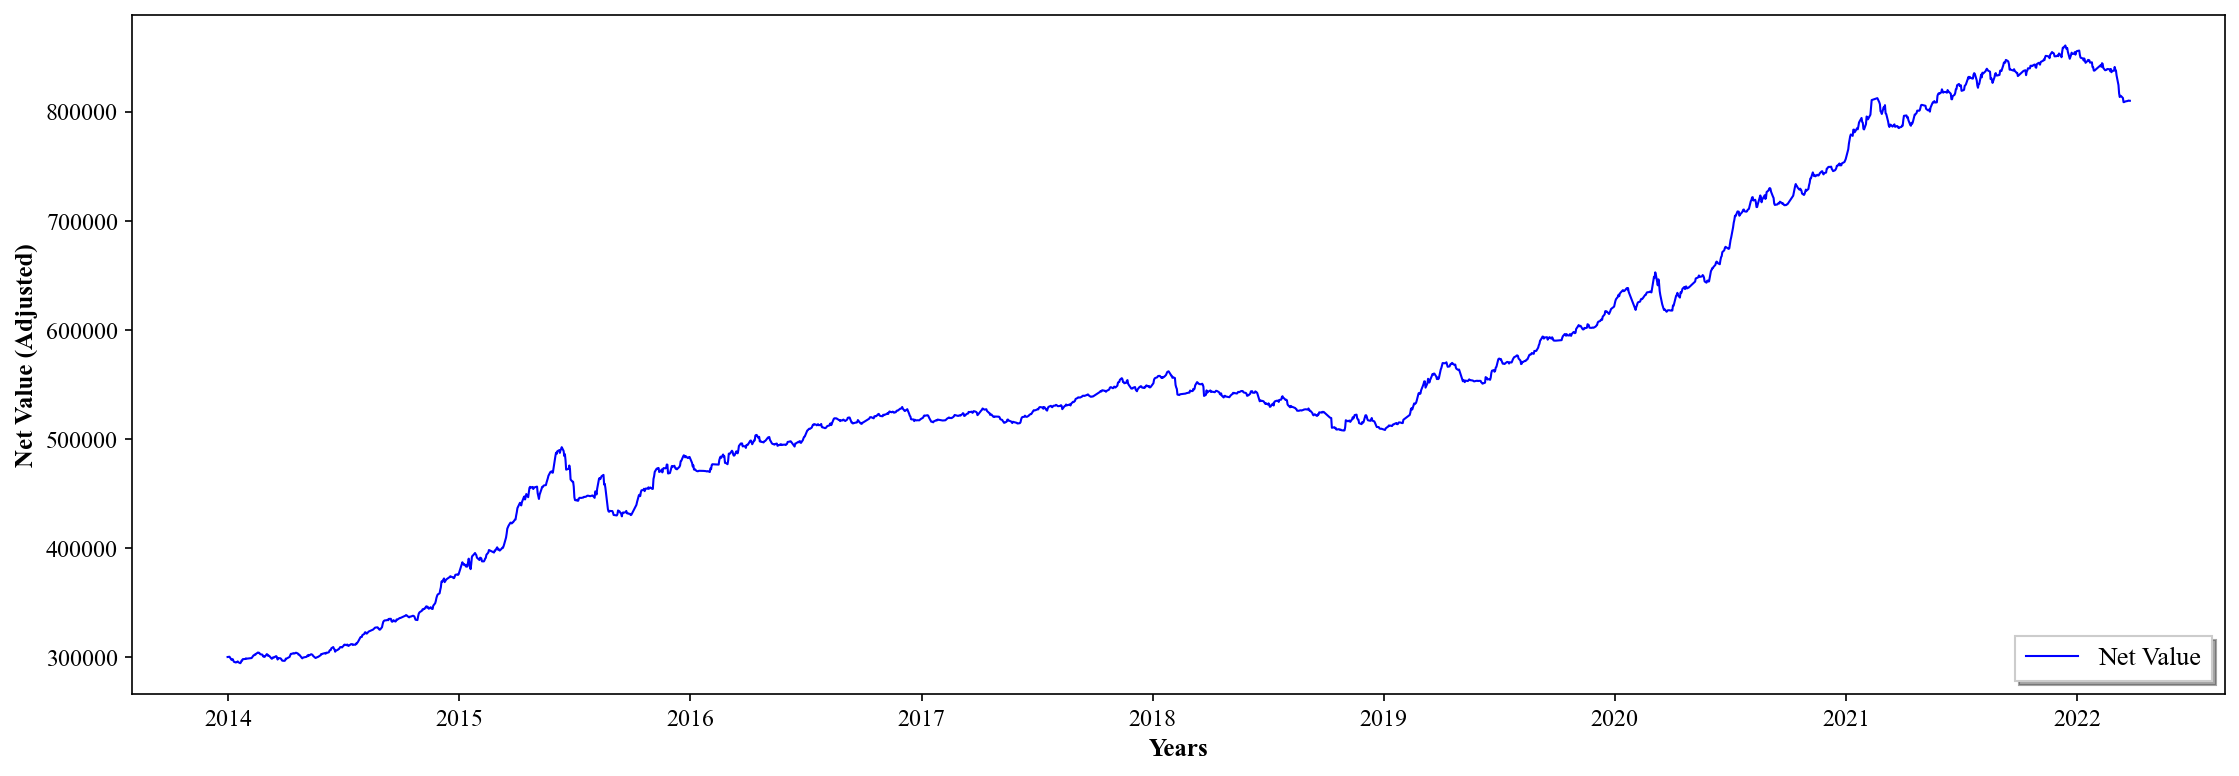

In [14]:
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(backtest_result.ACCOUNT_BALANCE, "-",color = "#0000FF",linewidth = 1,label = "Net Value")#非预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Net Value (Adjusted)",fontsize = 12,weight = 'bold')
ax1.set_xlabel("Years",fontsize = 12,weight = 'bold')
ax1.legend(["Net Value"], loc = 'upper left',fontsize = 12.5,shadow = "gray",fancybox = False)

# ax2 = ax1.twinx()#真实指数序列
# plt.ylim(-0.15, 1)
# ax2.plot((position_holdings.sum(axis = 1).loc[start_date:]), "-",color = "orange",linewidth = 1,label = "Position Percentage")#非预测对比序列
# ax2.set_ylabel("Position",fontsize = 12,weight = 'bold')

plt.legend(loc = 'lower right',fontsize = 12.5,shadow = "gray",fancybox = False)
plt.savefig('./Plots/AccountBalance(Free)',bbox_inches='tight')

In [15]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(backtest_result.ACCOUNT_BALANCE.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

1.8732817570083413

In [16]:
# annual return
empyrical.annual_return(backtest_result.ACCOUNT_BALANCE.pct_change().dropna().values,period = 'daily',annualization = 365)

0.1982620853144048

In [17]:
# max drawdown
((backtest_result.ACCOUNT_BALANCE.cummax() - backtest_result.ACCOUNT_BALANCE)/(backtest_result.ACCOUNT_BALANCE.cummax())).max()

0.12881280759127103